In [1]:
from crp.attribution import CondAttribution
from zennit.attribution import Gradient
from zennit.canonizers import CompositeCanonizer
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.visualization import FeatureVisualization
from crp.image import plot_grid

from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
import zennit as zen
import torch.nn as nn
import torch
import zennit.torchvision as ztv
from crp.image import imgify


from relevance import plot_relevance
from model import get_vggs_and_path, get_resnets_and_path, get_remote_models_and_path
from plot_and_print import plot_tile
from data_loader import TileLoader
import os
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from data_loader import get_data_loaders, get_dataset, STDataset


import torchvision.transforms as T

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


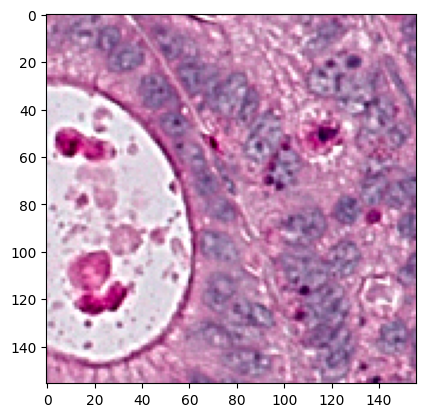

In [2]:
models = get_remote_models_and_path()
img_paths = []
img_paths.append("../Test_Data/p026/Tiles_156/p026_11_60.tiff")

loader = TileLoader()
for path in img_paths:
    data = loader.open(path).unsqueeze(0)
    data.requires_grad_(True)
    plot_tile(path)
    
cc = ChannelConcept()

data_dir = "../Training_Data/"
dataset = get_dataset(data_dir)
from torchvision import transforms

class STDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, device="mps", transforms=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            # mean and std of the whole dataset
            transforms.Normalize([0.7406, 0.5331, 0.7059], [0.1651, 0.2174, 0.1574])
            ])):
        self.dataframe = dataframe
        self.transforms = transforms
        self.device = device

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        gene_names = list(self.dataframe)[1:]
        gene_vals = []
        row = self.dataframe.iloc[index]
        a = Image.open(row["tile"]).convert("RGB")
        # print(x.size)
        for j in gene_names:
            gene_val = float(row[j])
            gene_vals.append(gene_val)
        e = row["tile"]
        # apply normalization transforms as for pretrained colon classifier
        a = self.transforms(a)
        a = a.to(self.device)
        return a, 0
datasetST = STDataset(dataset)

In [3]:
for model, model_path in models:
    for path in img_paths:
        data = loader.open(path).unsqueeze(0)
        data.requires_grad_(True)
        #print(type(model.pretrained))
        if type(model.pretrained).__name__ == "VGG":
            composite = zen.composites.EpsilonPlusFlat(canonizers=[ztv.VGGCanonizer()])
        else:
            composite = zen.composites.EpsilonPlusFlat(canonizers=[ztv.ResNetCanonizer()])
            
        print("selected", type(composite.canonizers[0]).__name__, "for model", model_path)
        attribution = CondAttribution(model, no_param_grad=True)
        #print(model)
        if type(model.pretrained).__name__ == "VGG":
            layer_type = model.pretrained.classifier[-1].__class__
            print(model.pretrained.classifier[-1])
            layer_name = get_layer_names(model, [nn.Linear])[-3]
        else:
            layer_type = model.pretrained.layer1[0].__class__
            # select last bottleneck module
            layer_name = get_layer_names(model, [layer_type])[-1]
        #print(layer_type)
        
        print(layer_name)
        conditions = [{'y': [0]}]
        attr = attribution(data, conditions, composite, record_layer=[layer_name])
        
        #print(attr.activations[layer_name].shape, attr.relevances[layer_name].shape)
        # attr[1]["features.40"].shape, attr[2]["features.40"].shape # is equivalent
        rel_c = cc.attribute(attr.relevances[layer_name], abs_norm=True)
        #print(rel_c.shape)
        #print(rel_c)
        rel_values, concept_ids = torch.topk(rel_c[0], 7)
        print(concept_ids, rel_values*100)
        position = path.find('models') + len('models')
        base_path = os.path.basename(model_path[position:-3])
        print(base_path)
        if os.path.exists(base_path):
            print(base_path, "already exists, continue..")
            fv_path = "output_crp_" + os.path.basename(model_path[position:-3])
            cc = ChannelConcept()
    
            layer_names = get_layer_names(model, [layer_type])
            layer_map = {layer : cc for layer in layer_names}
            preprocessing =  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            fv = FeatureVisualization(attribution, datasetST, layer_map, preprocess_fn=preprocessing, path=fv_path)
            #saved_files = fv.run(composite, 0, len(datasetST), 32, 100)
            ref_c = fv.get_max_reference(concept_ids, "pretrained.layer4.1", "relevance", (0, 8), composite=composite, plot_fn=None)
    
            plot_grid(ref_c, figsize=(6, 9))
            continue
        os.mkdir("./" + base_path)
        fv_path = "output_crp_" + os.path.basename(model_path[position:-3])
        cc = ChannelConcept()

        layer_names = get_layer_names(model, [layer_type])
        layer_map = {layer : cc for layer in layer_names}
        preprocessing =  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        fv = FeatureVisualization(attribution, datasetST, layer_map, preprocess_fn=preprocessing, path=fv_path)
        saved_files = fv.run(composite, 0, len(datasetST), 32, 100)
        ref_c = fv.get_max_reference(concept_ids, "pretrained.layer4.1", "relevance", (0, 8), composite=composite, plot_fn=None)

        plot_grid(ref_c, figsize=(6, 9))
    

selected ResNetCanonizer for model ../remote_models/new/models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt
pretrained.layer4.1
tensor([180, 422, 476, 446,  77, 489, 299]) tensor([2.1730, 1.5149, 1.2771, 1.0671, 1.0163, 0.9634, 0.9497])
Res18_1000_ep_29
Res18_1000_ep_29 already exists, continue..


FileNotFoundError: [Errno 2] No such file or directory: 'output_crp_Res18_1000_ep_29/RelMax_sum_normed/pretrained.layer4.1_data.npy'

In [ ]:
for model, model_path in models:
    for path in img_paths:
        data = loader.open(path).unsqueeze(0)
        data.requires_grad_(True)
        #print(type(model.pretrained))
        if type(model.pretrained).__name__ == "VGG":
            composite = zen.composites.EpsilonPlusFlat(canonizers=[ztv.VGGCanonizer()])
        else:
            composite = zen.composites.EpsilonPlusFlat(canonizers=[ztv.ResNetCanonizer()])
            
        print("selected", type(composite.canonizers[0]).__name__, "for model", model_path)
        attribution = CondAttribution(model, no_param_grad=True)
        #print(model)
        if type(model.pretrained).__name__ == "VGG":
            layer_type = model.pretrained.classifier[-1].__class__
            print(model.pretrained.classifier[-1])
            layer_name = get_layer_names(model, [nn.Linear])[-3]
        else:
            layer_type = model.pretrained.layer1[0].__class__
            # select last bottleneck module
            layer_name = get_layer_names(model, [layer_type])[-1]
        #print(layer_type)
        
        #print(layer_name)
        conditions = [{'y': [0]}]
        attr = attribution(data, conditions, composite, record_layer=[layer_name])
        
        #print(attr.activations[layer_name].shape, attr.relevances[layer_name].shape)
        # attr[1]["features.40"].shape, attr[2]["features.40"].shape # is equivalent
        rel_c = cc.attribute(attr.relevances[layer_name], abs_norm=True)
        #print(rel_c.shape)
        #print(rel_c)
        rel_values, concept_ids = torch.topk(rel_c[0], 7)
        print(concept_ids, rel_values*100)
        position = model_path.find('/models/') + len('/models/')
        base_path = "../crp_out/" + model_path[position:-3]
        
        #if the file exists then just plot
        if os.path.exists(base_path):
            print(model_path)
            #print(base_path, "already exists, continue..")
            fv_path = "output_crp_" + os.path.basename(model_path[position:-3])
            cc = ChannelConcept()
    
            layer_names = get_layer_names(model, [layer_type])
            layer_map = {layer : cc for layer in layer_names}
            preprocessing =  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            fv = FeatureVisualization(attribution, datasetST, layer_map, preprocess_fn=preprocessing, path=fv_path)
            #saved_files = fv.run(composite, 0, len(datasetST), 32, 100)
            ref_c = fv.get_max_reference(concept_ids, layer_names[-1], "relevance", (0, 8), composite=composite, plot_fn=None)
    
            plot_grid(ref_c, figsize=(6, 9))
            continue
        os.makedirs(base_path, exist_ok=True)

        fv_path = base_path
        cc = ChannelConcept()

        layer_names = get_layer_names(model, [layer_type])
        layer_map = {layer : cc for layer in layer_names}
        preprocessing =  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        fv = FeatureVisualization(attribution, datasetST, layer_map, preprocess_fn=preprocessing, path=fv_path)
        saved_files = fv.run(composite, 0, len(datasetST), 32, 100)
        ref_c = fv.get_max_reference(concept_ids, "pretrained.layer4.1", "relevance", (0, 8), composite=composite, plot_fn=None)

        plot_grid(ref_c, figsize=(6, 9))
        plt.show()

selected ResNetCanonizer for model ../remote_models/new/models/res18/RUBCNL_Res18/Res18_1000_ep_29.pt
tensor([180, 422, 476, 446,  77, 489, 299]) tensor([2.1730, 1.5149, 1.2771, 1.0671, 1.0163, 0.9634, 0.9497])
Running Analysis...


100%|██████████| 806/806 [1:14:01<00:00,  5.51s/it]


100%|██████████| 72/72 [00:00<00:00, 486.46it/s]
/Users/jona/.pyenv/versions/3.10.7/lib/python3.10/site-packages/zennit/image.py:184: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)
/Users/jona/.pyenv/versions/3.10.7/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


selected ResNetCanonizer for model ../remote_models/new/models/res18/RUBCNL_Res18_ciga/Res18_ep_29.pt
tensor([116,  64, 355,  39,  12,  70, 305]) tensor([1.2247, 1.1964, 1.1688, 1.1457, 1.1070, 1.0951, 1.0864])
Running Analysis...


100%|██████████| 806/806 [1:16:34<00:00,  5.70s/it]


100%|██████████| 72/72 [00:00<00:00, 613.22it/s]


selected ResNetCanonizer for model ../remote_models/new/models/res18/RUBCNL_Res18_ciga_drop/Res18Dropout_ep_29.pt
tensor([281, 334, 271, 116, 150, 190, 355]) tensor([1.4850, 1.2501, 1.2470, 1.2051, 1.0906, 1.0864, 1.0841])
Running Analysis...


100%|██████████| 806/806 [1:15:53<00:00,  5.65s/it]


100%|██████████| 72/72 [00:00<00:00, 589.83it/s]


selected ResNetCanonizer for model ../remote_models/new/models/res18/RUBCNL_Res18_freeze/Res18_1000_ep_29.pt
tensor([321, 280, 403, 364, 206, 359,  68]) tensor([2.3959, 1.3535, 1.1841, 1.0870, 0.9156, 0.8978, 0.7987])
Running Analysis...


100%|██████████| 806/806 [1:18:04<00:00,  5.81s/it]


100%|██████████| 72/72 [00:00<00:00, 476.94it/s]


selected ResNetCanonizer for model ../remote_models/new/models/res18/RUBCNL_Res18_random/Res18_1000_ep_29.pt
tensor([165,  42, 483, 191, 367, 422, 476]) tensor([2.0210, 1.7897, 1.6762, 1.6679, 1.4761, 1.3742, 1.3273])
Running Analysis...


100%|██████████| 806/806 [1:11:08<00:00,  5.30s/it]


100%|██████████| 72/72 [00:00<00:00, 1231.99it/s]


selected ResNetCanonizer for model ../remote_models/new/models/res50/RUBCNL_Res50/MyNet2_ep_29.pt
tensor([ 691,  969,  635, 1434,  559, 1199,  174]) tensor([31.3987,  3.4074,  1.1464,  1.0109,  0.9393,  0.9095,  0.8967])
Running Analysis...


 97%|█████████▋| 780/806 [3:49:30<07:40, 17.70s/it]  